In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import segmentation_models as sm
from keras.metrics import MeanIoU
from keras.utils import to_categorical


Segmentation Models: using `keras` framework.


In [2]:
Forest = np.array((255, 255, 255))
NotForest = np.array((0, 0, 0))

def rgb_to_2D_label(label):
    if len(label.shape) == 3: 
        label = label[:,:,:3]
    if len(label.shape) == 4: 
        label = label[:,:,:,:3]

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == NotForest, axis=-1)] = 0
    label_seg [np.all(label==Forest, axis=-1)] = 1



    if len(label.shape) == 3: 
        label_seg = label_seg[:,:,0]
    if len(label.shape) == 4: 
        label_seg = label_seg[:,:,:,0]
        
    return label_seg

def preprocess_data(img, mask, num_class):
    img = img.astype("float") / 255.0
    mask = rgb_to_2D_label(mask)
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

In [3]:
seed=42
batch_size= 32
n_classes=2

In [4]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [5]:
train_img_path = r'.\dataset\Forest Segmented\train_data\train_image'
train_mask_path = r'.\dataset\Forest Segmented\train_data\train_mask'
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

val_img_path = r'.\dataset\Forest Segmented\train_data\val_image'
val_mask_path = r'.\dataset\Forest Segmented\train_data\val_mask'
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

In [6]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


In [7]:
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

metrics = [sm.metrics.iou_score]
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [8]:
num_train_imgs = len(os.listdir(r'.\dataset\Forest Segmented\train_data\train_image\train'))
num_val_images = len(os.listdir(r'.\dataset\Forest Segmented\train_data\val_image\val'))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

EPOCHS = 50

In [9]:
history=model.fit(
          train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=EPOCHS,
          verbose=1,
          validation_steps=val_steps_per_epoch,
          validation_data=val_img_gen)

Found 3831 images belonging to 1 classes.
Found 3831 images belonging to 1 classes.
Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.4858 - iou_score: 0.4999Found 1277 images belonging to 1 classes.
Found 1277 images belonging to 1 classes.
119/119 [==============================] - 61s 427ms/step - loss: 0.4858 - iou_score: 0.4999 - val_loss: 3.7317 - val_iou_score: 0.2055
Epoch 2/50
119/119 [==============================] - 53s 422ms/step - loss: 0.3953 - iou_score: 0.5833 - val_loss: 2.7530 - val_iou_score: 0.2062
Epoch 3/50
119/119 [==============================] - 50s 424ms/step - loss: 0.3606 - iou_score: 0.6159 - val_loss: 2.5500 - val_iou_score: 0.2050
Epoch 4/50
119/119 [==============================] - 50s 421ms/step - loss: 0.3421 - iou_score: 0.6347 - val_loss: 3.6271 - val_iou_score: 0.2002
Epoch 5/50
119/119 [==============================] - 49s 411ms/step - loss: 0.3094 - iou_score: 0.6652 - val_loss: 3.2178 - val_iou_score: 0.1999
Epoch 6/50
1

In [10]:
model.save('.\models\Method1_Model.h5')

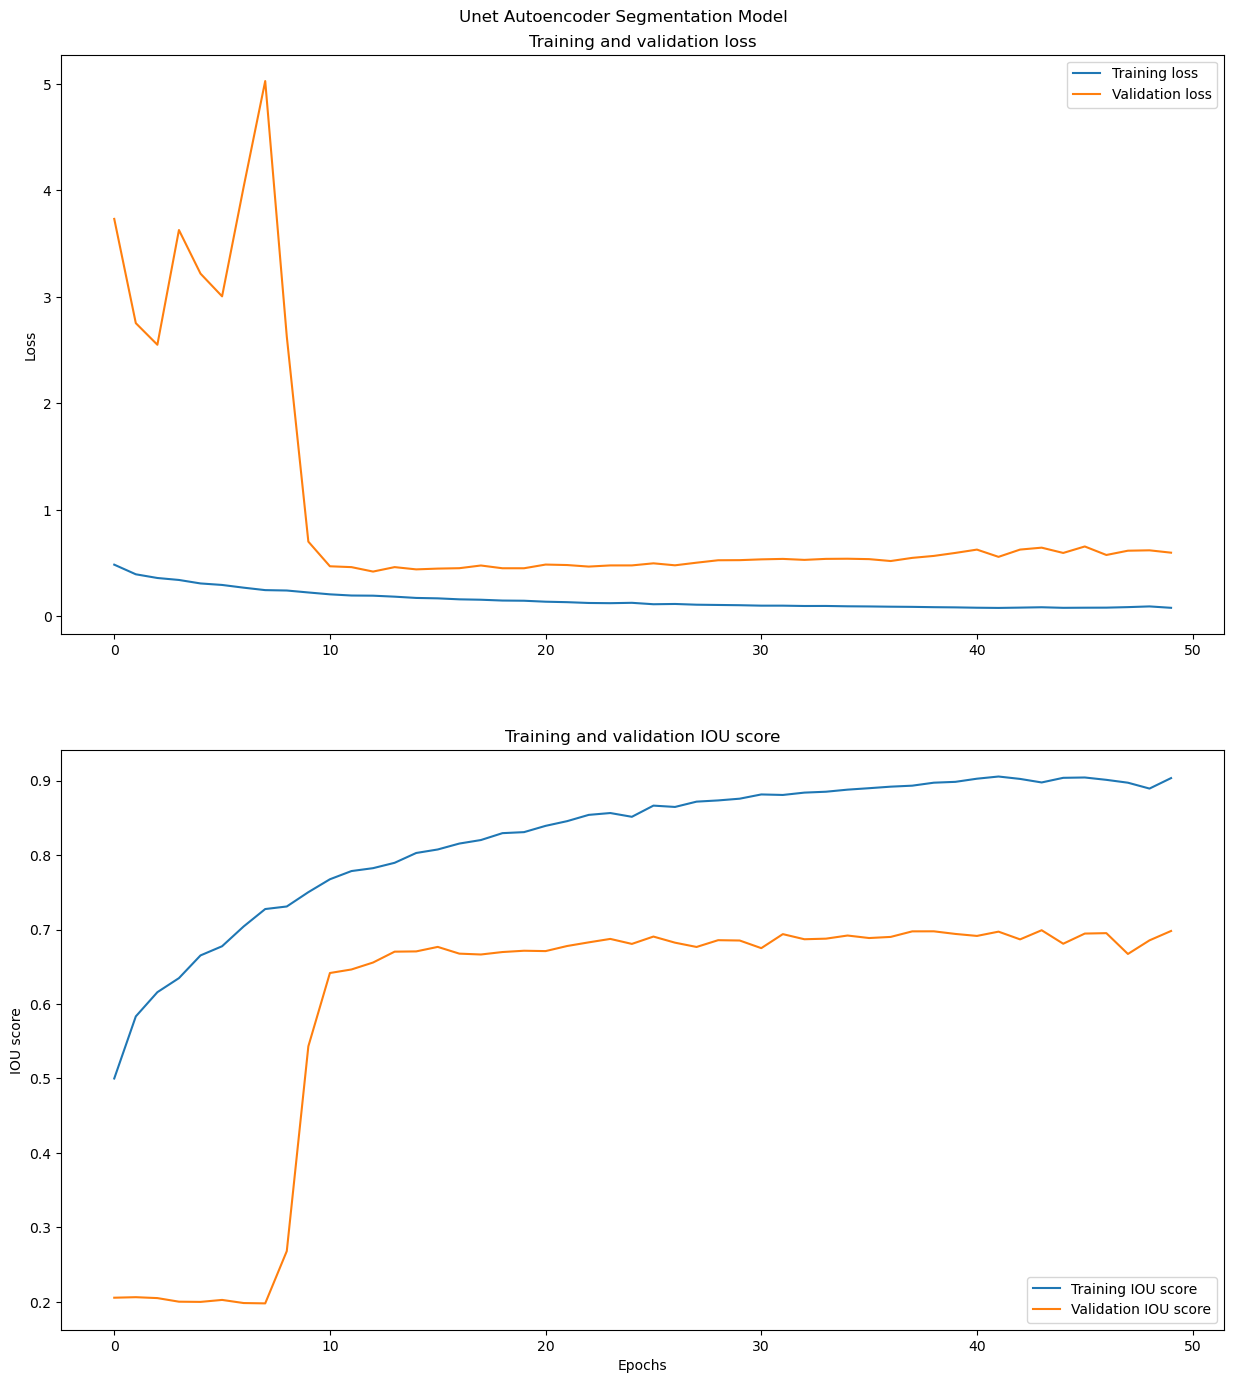

In [11]:
fig, axs = plt.subplots(2, 1)
    
fig.set_figwidth(15)
fig.set_figheight(15)
fig.suptitle("Unet Autoencoder Segmentation Model")
plt.xlabel('Epochs', fontsize=10)
    
axs[0].set_title("Training and validation loss")
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_ylabel('Loss')
axs[0].legend(['Training loss', 'Validation loss'], loc="upper right")


axs[1].set_title("Training and validation IOU score")
axs[1].plot(history.history['iou_score'])
axs[1].plot(history.history['val_iou_score'])
axs[1].set_ylabel('IOU score')
axs[1].legend(['Training IOU score', 'Validation IOU score'], loc="lower right")


fig.subplots_adjust(bottom=0.1, top=0.95)